<a href="https://colab.research.google.com/github/GerardoFesta/DLforJITDefectPrediction/blob/main/Loader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Caricamento Liberie



In [11]:
from cmath import e
import pandas as pd
import torch

from torch import nn
from torch.utils.data import Dataset

import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from TrainData import TrainData
from TestData import TestData
from BinaryClassificator import BinaryClassificator

from sklearn.preprocessing import StandardScaler
import sklearn.metrics as skmetrics 

Funzione accuracy usata per il modello

In [2]:
def accuracy(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred)) #risultati sigmoidali arrotondati
    correct_results_sum = (y_pred_tag == y_test).sum().float() # num risultati corretti
    acc = correct_results_sum/y_test.shape[0] #y_test.spape[0] è il numero di risultati totali
    acc = torch.round(acc * 100)
    #si fa media e si ritorna accuracy
    return acc

Caricamento dei dati, splitting in train e test set

In [3]:
df = pd.read_csv("data_for_analysis.csv")
df = df.drop(columns=['PROJECT', "TIME"])


device = torch.device('cpu')
df['FILE_BUGGY'] = df['FILE_BUGGY'].astype(int)

X = df.iloc[:, 0:-1] #dataset senza label predizione
y = df.iloc[:, -1] #valori da pred.
print(sum(df['FILE_BUGGY'])/len(df.index))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=69) #splitting in train e test
print(sum(y_train)/len(y_train))
print(sum(y_test)/len(y_test))


0.3747678018575851
0.3758578431372549
0.3704076367389061



Parametri rete


In [4]:
EPOCHS = 50
BATCH_SIZE = 1024
LEARNING_RATE = 0.001

Scaling dei dati e creazione tensore di train e test

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(type(y_train.to_numpy))
#Crea tensore di training
torch.FloatTensor(X_train)
torch.FloatTensor(y_train.to_numpy())


<class 'method'>


tensor([1., 0., 0.,  ..., 1., 1., 0.])

Creazione Loader

In [6]:
#Crea tensore di test
train_data = TrainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train.to_numpy()))
test_data = TestData(torch.FloatTensor(X_test))
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)


Creazione Modello e definizione optimizer e loss

In [7]:
model = BinaryClassificator(24, 13,  1)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

BinaryClassificator(
  (fc1): Linear(in_features=24, out_features=13, bias=True)
  (fc2): Linear(in_features=13, out_features=1, bias=True)
)


Training del modello

In [8]:
model.train()
for epoch in range(EPOCHS):  

    running_loss = 0.0
    running_acc = 0.0
    for X_batch, y_batch in train_loader:
        
        #manda i batch al device 
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        #azzera gradiente
        optimizer.zero_grad()
        #predict
        y_pred = model(X_batch)
        #calcola loss e accuracy
        #y_pred_test = torch.sigmoid(y_pred)
       
        #y_pred_test = [1 if x>=.5 else 0 for x in y_pred_test]
      

        #print(y_batch.shape)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = accuracy(y_pred, y_batch.unsqueeze(1))
        #backpropagation della loss
        loss.backward()
        #ottimizzazione
        optimizer.step()
        
        #somma della loss e dell'accuracy per il batch
        running_loss += loss.item()
        running_acc += acc.item()                   
        
    
    print(f'Epoch {epoch}: | Loss: {running_loss/len(train_loader):.5f} | Acc: {running_acc/len(train_loader):.3f}')


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch 0: | Loss: 0.65194 | Acc: 62.632
Epoch 1: | Loss: 0.61909 | Acc: 65.704
Epoch 2: | Loss: 0.61271 | Acc: 66.303
Epoch 3: | Loss: 0.60931 | Acc: 66.572
Epoch 4: | Loss: 0.60575 | Acc: 66.730
Epoch 5: | Loss: 0.60338 | Acc: 66.980
Epoch 6: | Loss: 0.60069 | Acc: 67.151
Epoch 7: | Loss: 0.59863 | Acc: 67.270
Epoch 8: | Loss: 0.59660 | Acc: 67.447
Epoch 9: | Loss: 0.59469 | Acc: 67.546
Epoch 10: | Loss: 0.59306 | Acc: 67.697
Epoch 11: | Loss: 0.59149 | Acc: 67.849
Epoch 12: | Loss: 0.59022 | Acc: 68.039
Epoch 13: | Loss: 0.58927 | Acc: 68.132
Epoch 14: | Loss: 0.58803 | Acc: 68.250
Epoch 15: | Loss: 0.58731 | Acc: 68.257
Epoch 16: | Loss: 0.58643 | Acc: 68.349
Epoch 17: | Loss: 0.58571 | Acc: 68.480
Epoch 18: | Loss: 0.58495 | Acc: 68.487
Epoch 19: | Loss: 0.58431 | Acc: 68.579
Epoch 20: | Loss: 0.58376 | Acc: 68.612
Epoch 21: | Loss: 0.58299 | Acc: 68.697
Epoch 22: | Loss: 0.58244 | Acc: 68.691
Epoch 23: | Loss: 0.58212 | Acc: 68.789
Epoch 24: | Loss: 0.58167 | Acc: 68.809
Epoch 25: 

Test del modello

In [9]:
y_pred_list = []
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

Stampa delle metriche

              precision    recall  f1-score   support

           0       0.72      0.83      0.77     24403
           1       0.61      0.45      0.52     14357

    accuracy                           0.69     38760
   macro avg       0.67      0.64      0.65     38760
weighted avg       0.68      0.69      0.68     38760



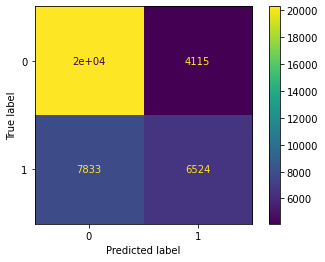

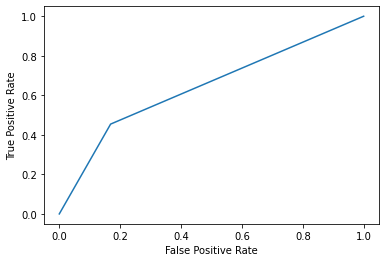

In [15]:
print(classification_report(y_test, y_pred_list))
conf_mat = confusion_matrix(y_test, y_pred_list)
skmetrics.ConfusionMatrixDisplay(conf_mat).plot()
fpr, tpr, _ = skmetrics.roc_curve(y_test, y_pred_list)
roc_display = skmetrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
